# Sample Analysis with SodaPy and Socrata Query Language (SoQL)
Mark Bauer

Table of Contents
=================

   1. Introduction
   2. Importing Libraries
   3. Answering Questions about NYC 311 Complaints
       * 3.1 Most NYC 311 Complaints by Complaint Type
       * 3.2 Most NYC 311 Complaints by Day
       * 3.3 Analyzing NYC 311 Datasets with the Most Downloads
       * 3.4 Analyzing NYC 311 Datasets with the Most Page Views
   4. Answering questions about NYC 311 Street Flooding Complaints
       * 4.1 Searching the dataset for the word "flood" in the complaint_type field
       * 4.2 Searching the dataset for the word "flood" in the descriptor field
       * 4.3 Displaying the highest number of street flooding complaints by day
       * 4.4 Selecting the rows and columns where the descriptor field = 'Street Flooding'      

# 1. Introduction  
This notebook demonstrates basic queries using SoQL, the Socrata Query Language. 

# 2. Importing Libraries

In [1]:
# importing libraries
import pandas as pd
import numpy as np
from sodapy import Socrata
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import urllib.parse

sns.set_theme()
plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [2]:
## documention for installing watermark: https://github.com/rasbt/watermark
%reload_ext watermark
%watermark -t -d -v -p pandas,sodapy

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

pandas: 1.4.2
sodapy: 2.2.0



# 3. Answering Questions about NYC 311 Complaints with SoQL

## 3.1 Most NYC 311 Complaints by Complaint Type

In [3]:
# Source domain for NYC Open Data on Socrata
socrata_domain = 'data.cityofnewyork.us'

# Data set id for NYC 311 on NYC Open Data on Socrata
socrata_dataset_identifier = 'erm2-nwe9'

""" Socrata - The main class that interacts with the SODA API. We pass the source domain value
of NYC Open data, the app token as 'None', and set the timeout parameter for '1,000 seconds'
"""
client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select the complaint_type and the count of complaint_type columns 
grouped by complaint_type, sorted by the count of complaint_type in descending order
and limit our records to 1,000
"""

query = """
SELECT 
    complaint_type, 
    count(unique_key) AS count
GROUP BY 
    complaint_type
ORDER BY 
    count DESC
LIMIT 
    1000
"""

""" Requesting data from the NYC 311 dataset
and passing our query as a full SoQL query string
"""
results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head(10)

shape of data: (485, 2)


,complaint_type,count
0,Noise - Residential,3113342
1,Illegal Parking,2076484
2,HEAT/HOT WATER,1980885
3,Blocked Driveway,1428642
4,Street Condition,1207661
5,Street Light Condition,1113711
6,Noise - Street/Sidewalk,1086084
7,Request Large Bulky Item Collection,1073753
8,HEATING,887869
9,PLUMBING,886377


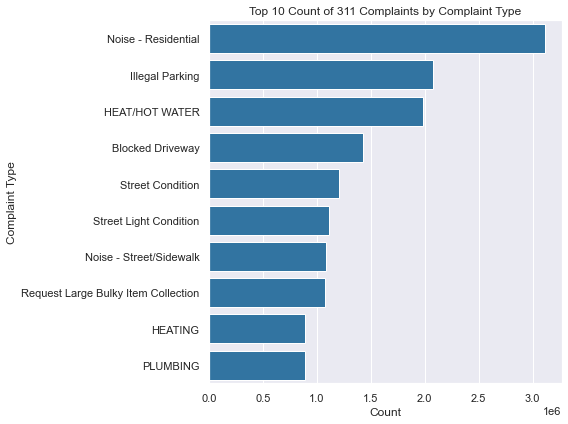

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

results_df['count'] = results_df['count'].astype(int)

data = (
    results_df
    .sort_values(by='count', ascending=False)
    .head(10)
)

sns.barplot(
    data=data,
    y='complaint_type',
    x='count',
    color='#1f77b4'
)

plt.title('Top 10 Count of 311 Complaints by Complaint Type')
plt.xlabel('Count')
plt.ylabel('Complaint Type')
plt.tight_layout()

In [5]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select the complaint_type and the count of complaint_type columns 
grouped by complaint_type, sorted by the count of complaint_type in descending order
and limit our records to 1,000
"""

query = """
SELECT 
    complaint_type, 
    descriptor,
    count(unique_key) AS count
GROUP BY 
    complaint_type, descriptor
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head(10)

shape of data: (1000, 3)


,complaint_type,descriptor,count
0,Noise - Residential,Loud Music/Party,2083361
1,HEAT/HOT WATER,ENTIRE BUILDING,1292536
2,Request Large Bulky Item Collection,Request Large Bulky Item Collection,1073753
3,Blocked Driveway,No Access,1066803
4,HEATING,HEAT,868960
5,Noise - Street/Sidewalk,Loud Music/Party,847513
6,Street Light Condition,Street Light Out,820702
7,Noise - Residential,Banging/Pounding,790135
8,Street Condition,Pothole,731873
9,HEAT/HOT WATER,APARTMENT ONLY,688349


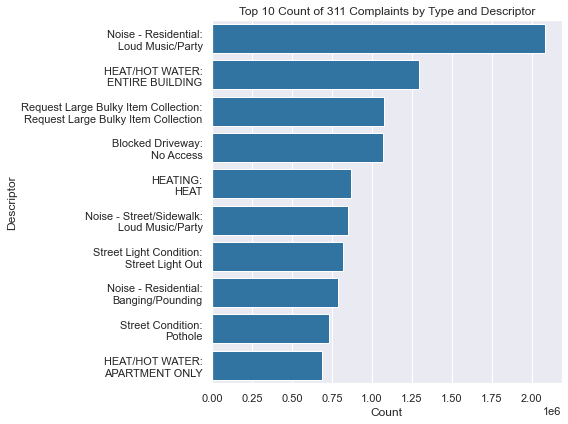

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

results_df['count'] = results_df['count'].astype(int)
results_df['type_full'] = results_df['complaint_type'] + ':\n' + results_df['descriptor']

data = (
    results_df
    .sort_values(by='count', ascending=False)
    .head(10)
)

sns.barplot(
    data=data,
    y='type_full',
    x='count',
    color='#1f77b4'
)

plt.title('Top 10 Count of 311 Complaints by Type and Descriptor')
plt.xlabel('Count')
plt.ylabel('Descriptor')
plt.tight_layout()

## 3.2 Most NYC 311 Complaints by Day

In [7]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select the day and count day grouped by day,
sort by count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    date_trunc_ymd(created_date) AS day, 
    count(unique_key) AS count
GROUP BY 
    day
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head(10)

shape of data: (1000, 2)


,day,count
0,2020-08-04T00:00:00.000,24415
1,2020-08-05T00:00:00.000,19560
2,2020-07-05T00:00:00.000,16916
3,2020-06-21T00:00:00.000,15883
4,2020-06-20T00:00:00.000,15825
5,2020-07-04T00:00:00.000,15794
6,2021-09-02T00:00:00.000,15205
7,2020-06-28T00:00:00.000,14057
8,2021-10-28T00:00:00.000,13575
9,2020-08-06T00:00:00.000,13288


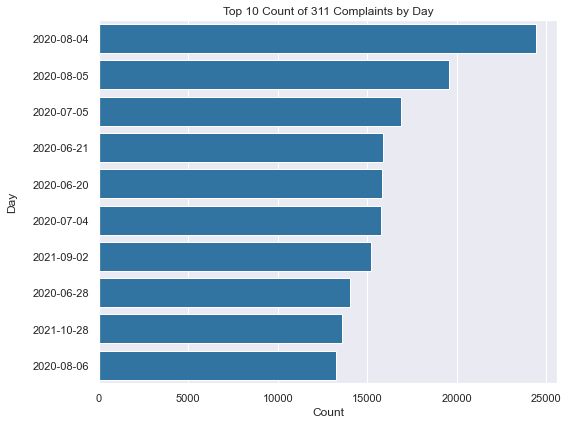

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

results_df['day_fmt'] = pd.to_datetime(results_df['day']).astype(str)
results_df['count'] = results_df['count'].astype(int)

data = (
    results_df
    .sort_values(by='count', ascending=False)
    .head(10)
)

sns.barplot(
    data=data,
    y='day_fmt',
    x='count',
    color='#1f77b4'
)

plt.title('Top 10 Count of 311 Complaints by Day')
plt.xlabel('Count')
plt.ylabel('Day\n')
plt.tight_layout()

In [9]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

query = """
SELECT 
    date_trunc_ymd(created_date) AS day,
    complaint_type, 
    descriptor,
    count(unique_key) AS count
WHERE
    date_trunc_ymd(created_date) == '2020-08-04T00:00:00.000'
GROUP BY 
    day, complaint_type, descriptor
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head(10)

shape of data: (455, 4)


,day,complaint_type,descriptor,count
0,2020-08-04T00:00:00.000,Damaged Tree,Entire Tree Has Fallen Down,7848
1,2020-08-04T00:00:00.000,Damaged Tree,Branch or Limb Has Fallen Down,4971
2,2020-08-04T00:00:00.000,Damaged Tree,Branch Cracked and Will Fall,1330
3,2020-08-04T00:00:00.000,Request Large Bulky Item Collection,Request Large Bulky Item Collection,909
4,2020-08-04T00:00:00.000,Noise - Residential,Loud Music/Party,762
5,2020-08-04T00:00:00.000,Damaged Tree,Tree Leaning/Uprooted,510
6,2020-08-04T00:00:00.000,Street Light Condition,Street Light Out,397
7,2020-08-04T00:00:00.000,Traffic Signal Condition,Controller,353
8,2020-08-04T00:00:00.000,Noise - Street/Sidewalk,Loud Music/Party,263
9,2020-08-04T00:00:00.000,Blocked Driveway,No Access,259


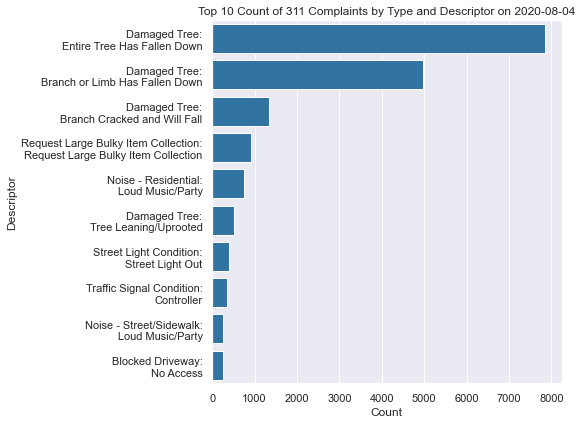

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

results_df['count'] = results_df['count'].astype(int)
results_df['type_full'] = results_df['complaint_type'] + ':\n' + results_df['descriptor']

data = (
    results_df
    .sort_values(by='count', ascending=False)
    .head(10)
)

sns.barplot(
    data=data,
    y='type_full',
    x='count',
    color='#1f77b4'
)

date = data.head(1)['day'].str.split('T').values[0][0]
plt.title('Top 10 Count of 311 Complaints by Type and Descriptor on {}'.format(date))
plt.xlabel('Count')
plt.ylabel('Descriptor')
plt.tight_layout()

In [11]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

query = """
SELECT 
    date_trunc_ymd(created_date) AS day,
    complaint_type, 
    descriptor,
    count(unique_key) AS count
WHERE
    date_trunc_ymd(created_date) == '2020-07-05T00:00:00.000'
GROUP BY 
    day, complaint_type, descriptor
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head(10)

shape of data: (330, 4)


,day,complaint_type,descriptor,count
0,2020-07-05T00:00:00.000,Noise - Residential,Loud Music/Party,4334
1,2020-07-05T00:00:00.000,Illegal Fireworks,N/A,4199
2,2020-07-05T00:00:00.000,Noise - Street/Sidewalk,Loud Music/Party,2837
3,2020-07-05T00:00:00.000,Request Large Bulky Item Collection,Request Large Bulky Item Collection,752
4,2020-07-05T00:00:00.000,Noise - Vehicle,Car/Truck Music,412
5,2020-07-05T00:00:00.000,Noise - Residential,Banging/Pounding,304
6,2020-07-05T00:00:00.000,Non-Emergency Police Matter,Social Distancing,239
7,2020-07-05T00:00:00.000,Blocked Driveway,No Access,206
8,2020-07-05T00:00:00.000,Noise - Commercial,Loud Music/Party,189
9,2020-07-05T00:00:00.000,Water System,Hydrant Running Full (WA4),188


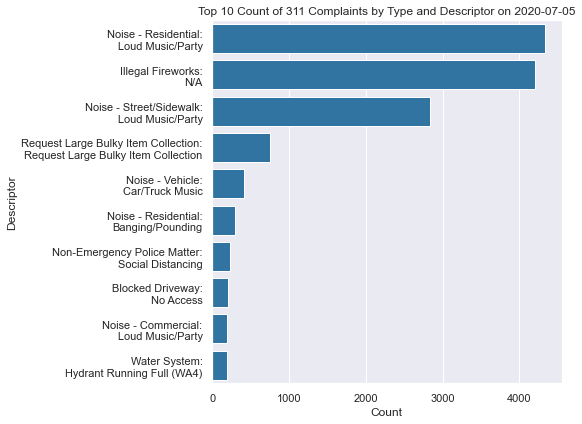

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

results_df['count'] = results_df['count'].astype(int)
results_df['type_full'] = results_df['complaint_type'] + ':\n' + results_df['descriptor']

data = (
    results_df
    .sort_values(by='count', ascending=False)
    .head(10)
)

sns.barplot(
    data=data,
    y='type_full',
    x='count',
    color='#1f77b4'
)

date = data.head(1)['day'].str.split('T').values[0][0]
plt.title('Top 10 Count of 311 Complaints by Type and Descriptor on {}'.format(date))
plt.xlabel('Count')
plt.ylabel('Descriptor')
plt.tight_layout()

## 3.3 Analyzing NYC 311 Datasets with the Most Downloads

In [13]:
client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

# Reading in a list of dictionaries of our data into a pandas DataFrame
df = pd.DataFrame.from_records(client.datasets())
client.close()

print(df.shape)
df.head()

(3526, 8)


,resource,classification,metadata,permalink,link,owner,creator,preview_image_url
0,"{'name': 'Civil Service List (Active)', 'id': ...","{'categories': [], 'tags': [], 'domain_categor...",{'domain': 'data.cityofnewyork.us'},https://data.cityofnewyork.us/d/vx8i-nprf,https://data.cityofnewyork.us/City-Government/...,"{'id': '5fuc-pqz2', 'user_type': 'interactive'...","{'id': '5fuc-pqz2', 'user_type': 'interactive'...",NaN
1,"{'name': 'DOB Job Application Filings', 'id': ...","{'categories': ['economy', 'environment', 'hou...",{'domain': 'data.cityofnewyork.us'},https://data.cityofnewyork.us/d/ic3t-wcy2,https://data.cityofnewyork.us/Housing-Developm...,"{'id': '5fuc-pqz2', 'user_type': 'interactive'...","{'id': '5fuc-pqz2', 'user_type': 'interactive'...",NaN
2,"{'name': 'TLC New Driver Application Status', ...","{'categories': ['transportation', 'environment...",{'domain': 'data.cityofnewyork.us'},https://data.cityofnewyork.us/d/dpec-ucu7,https://data.cityofnewyork.us/Transportation/T...,"{'id': '5fuc-pqz2', 'user_type': 'interactive'...","{'id': '5fuc-pqz2', 'user_type': 'interactive'...",NaN
3,"{'name': 'For Hire Vehicles (FHV) - Active', '...","{'categories': [], 'tags': [], 'domain_categor...",{'domain': 'data.cityofnewyork.us'},https://data.cityofnewyork.us/d/8wbx-tsch,https://data.cityofnewyork.us/Transportation/F...,"{'id': '5fuc-pqz2', 'user_type': 'interactive'...","{'id': '5fuc-pqz2', 'user_type': 'interactive'...",NaN
4,{'name': 'For Hire Vehicles (FHV) - Active Dri...,"{'categories': [], 'tags': [], 'domain_categor...",{'domain': 'data.cityofnewyork.us'},https://data.cityofnewyork.us/d/xjfq-wh2d,https://data.cityofnewyork.us/Transportation/F...,"{'id': '5fuc-pqz2', 'user_type': 'interactive'...","{'id': '5fuc-pqz2', 'user_type': 'interactive'...",NaN


In [14]:
# Reading the dictionary in the resource column into a pandas DataFrame
df = pd.DataFrame.from_records(df.resource)

print(df.shape)
df.head()

(3526, 25)


,name,id,parent_fxf,description,attribution,attribution_link,contact_email,type,updatedAt,createdAt,...,columns_datatype,columns_description,columns_format,download_count,provenance,lens_view_type,lens_display_type,blob_mime_type,hide_from_data_json,publication_date
0,Civil Service List (Active),vx8i-nprf,[],A Civil Service List consists of all candidate...,Department of Citywide Administrative Services...,None,None,dataset,2023-07-10T13:36:10.000Z,2016-06-14T21:12:15.000Z,...,"[Text, Text, Calendar date, Calendar date, Cal...",[A four (4) digit number that identifies a civ...,"[{'displayStyle': 'plain', 'align': 'left'}, {...",52692,official,tabular,table,None,False,2023-07-10T13:36:10.000Z
1,DOB Job Application Filings,ic3t-wcy2,[],This dataset contains all job applications sub...,Department of Buildings (DOB),None,None,dataset,2023-07-10T20:10:28.000Z,2013-04-18T15:18:56.000Z,...,"[Text, Text, Text, Number, Text, Text, Text, T...","[Hazardous, House Number of Residence or Comme...","[{'align': 'right'}, {'align': 'right'}, {'ali...",37213,official,tabular,table,None,False,2020-06-22T18:23:35.000Z
2,TLC New Driver Application Status,dpec-ucu7,[],THIS DATASET IS UPDATED SEVERAL TIMES PER DAY....,Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-10T22:13:56.000Z,2016-05-17T18:43:43.000Z,...,"[Text, Calendar date, Text, Text, Number, Text...",[Drug testing is required for Medallion and FH...,"[{'displayStyle': 'plain', 'align': 'left'}, {...",35485,official,tabular,table,None,False,2019-12-17T18:44:57.000Z
3,For Hire Vehicles (FHV) - Active,8wbx-tsch,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-10T18:54:08.000Z,2015-07-16T17:33:32.000Z,...,"[Text, Text, Text, Text, Text, Text, Calendar ...","[Hybrid vehicle indicator\n, Wheelchair Access...","[{'displayStyle': 'plain', 'align': 'left'}, {...",256759,official,tabular,table,None,False,2021-04-05T13:20:47.000Z
4,For Hire Vehicles (FHV) - Active Drivers,xjfq-wh2d,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-10T19:03:24.000Z,2015-07-16T17:24:02.000Z,...,"[Text, Calendar date, Text, Calendar date, Tex...","[Last Time Updated, Last Date Updated, WAV if ...","[{'displayStyle': 'plain', 'align': 'left'}, {...",351656,official,tabular,table,None,False,2023-07-10T19:03:24.000Z


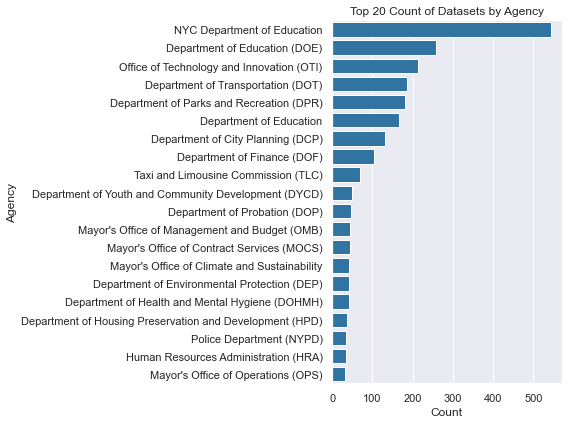

In [15]:
data = (
    df
    .groupby(by='attribution')['name']
    .count()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'name':'count'})
    .head(20)
)

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=data,
    y='attribution',
    x='count',
    color='#1f77b4'
)

plt.title('Top 20 Count of Datasets by Agency')
plt.xlabel('Count')
plt.ylabel('Agency')
plt.tight_layout()

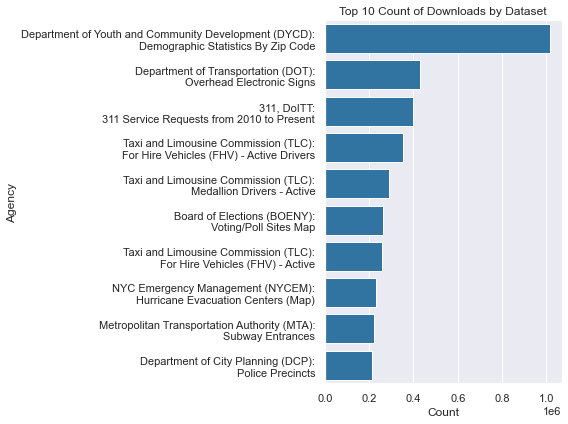

In [16]:
# Sorting the data sets by download_count
data = (df
 .loc[:, ['attribution', 'name', 'download_count']]
 .sort_values(by='download_count', ascending=False)
 .head(10)
)

data['full_name'] = data['attribution'] + ':\n' + data['name']


fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=data,
    y='full_name',
    x='download_count',
    color='#1f77b4'
)

plt.title('Top 10 Count of Downloads by Dataset')
plt.xlabel('Count')
plt.ylabel('Agency')
plt.tight_layout()

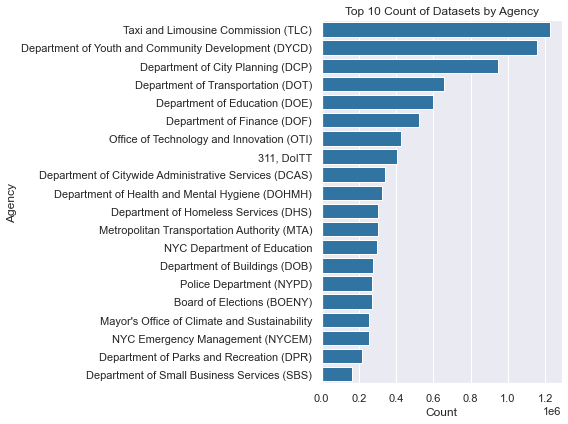

In [17]:
data = (
    df
    .groupby(by='attribution')['download_count']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .head(20)
)


fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=data,
    y='attribution',
    x='download_count',
    color='#1f77b4'
)

plt.title('Top 10 Count of Datasets by Agency')
plt.xlabel('Count')
plt.ylabel('Agency')
plt.tight_layout()

In [18]:
(df
 .groupby(by='attribution')['download_count']
 .mean()
 .sort_values(ascending=False)
 .round(0)
 .astype(int)
 .reset_index()
 .head(20)
)

,attribution,download_count
0,Board of Elections (BOENY),90412
1,Metropolitan Transportation Authority (MTA),75203
2,NYC Management Department (NYCEM),41530
3,"311, DoITT",33586
4,Department of Youth and Community Development ...,23642
5,NYC Emergency Management (NYCEM),19605
6,Broadway Theater,18530
7,Taxi and Limousine Commission (TLC),17536
8,Office of Payroll Administration (OPA),16630
9,Department of Information Technology & Telecom...,14703


In [19]:
(df
 .groupby(by='attribution')['download_count']
 .median()
 .sort_values(ascending=False)
 .round(0)
 .astype(int)
 .reset_index()
 .head(20)
)

,attribution,download_count
0,NYC Management Department (NYCEM),41530
1,Metropolitan Transportation Authority (MTA),32464
2,Broadway Theater,18530
3,Office of Payroll Administration (OPA),16630
4,Office of Administrative Trials and Hearings (...,11608
5,Mayor’s Office of Media and Entertainment (MOME),10774
6,Office of the Mayor (OTM),10406
7,Department of Edcuation,9599
8,Department of Mental Health and Hygeine,8635
9,Department of Information Technology & Telecom...,8020


## 3. 4 Analyzing NYC 311 Datasets with the Most Page Views

In [20]:
client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

In [21]:
# Reading in a list of dictionaries of our data into a pandas DataFrame
df = pd.DataFrame.from_records(client.datasets())
client.close()

df = pd.DataFrame.from_records(df.resource)

print(df.shape)
df.head()

(3526, 25)


,name,id,parent_fxf,description,attribution,attribution_link,contact_email,type,updatedAt,createdAt,...,columns_datatype,columns_description,columns_format,download_count,provenance,lens_view_type,lens_display_type,blob_mime_type,hide_from_data_json,publication_date
0,Civil Service List (Active),vx8i-nprf,[],A Civil Service List consists of all candidate...,Department of Citywide Administrative Services...,None,None,dataset,2023-07-10T13:36:10.000Z,2016-06-14T21:12:15.000Z,...,"[Text, Text, Calendar date, Calendar date, Cal...",[A four (4) digit number that identifies a civ...,"[{'displayStyle': 'plain', 'align': 'left'}, {...",52692,official,tabular,table,None,False,2023-07-10T13:36:10.000Z
1,DOB Job Application Filings,ic3t-wcy2,[],This dataset contains all job applications sub...,Department of Buildings (DOB),None,None,dataset,2023-07-10T20:10:28.000Z,2013-04-18T15:18:56.000Z,...,"[Text, Text, Text, Number, Text, Text, Text, T...","[Hazardous, House Number of Residence or Comme...","[{'align': 'right'}, {'align': 'right'}, {'ali...",37213,official,tabular,table,None,False,2020-06-22T18:23:35.000Z
2,TLC New Driver Application Status,dpec-ucu7,[],THIS DATASET IS UPDATED SEVERAL TIMES PER DAY....,Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-10T22:13:56.000Z,2016-05-17T18:43:43.000Z,...,"[Text, Calendar date, Text, Text, Number, Text...",[Drug testing is required for Medallion and FH...,"[{'displayStyle': 'plain', 'align': 'left'}, {...",35485,official,tabular,table,None,False,2019-12-17T18:44:57.000Z
3,For Hire Vehicles (FHV) - Active,8wbx-tsch,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-10T18:54:08.000Z,2015-07-16T17:33:32.000Z,...,"[Text, Text, Text, Text, Text, Text, Calendar ...","[Hybrid vehicle indicator\n, Wheelchair Access...","[{'displayStyle': 'plain', 'align': 'left'}, {...",256759,official,tabular,table,None,False,2021-04-05T13:20:47.000Z
4,For Hire Vehicles (FHV) - Active Drivers,xjfq-wh2d,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-10T19:03:24.000Z,2015-07-16T17:24:02.000Z,...,"[Text, Calendar date, Text, Calendar date, Tex...","[Last Time Updated, Last Date Updated, WAV if ...","[{'displayStyle': 'plain', 'align': 'left'}, {...",351656,official,tabular,table,None,False,2023-07-10T19:03:24.000Z


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3526 entries, 0 to 3525
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 3526 non-null   object
 1   id                   3526 non-null   object
 2   parent_fxf           3526 non-null   object
 3   description          3526 non-null   object
 4   attribution          3312 non-null   object
 5   attribution_link     408 non-null    object
 6   contact_email        0 non-null      object
 7   type                 3526 non-null   object
 8   updatedAt            3526 non-null   object
 9   createdAt            3526 non-null   object
 10  metadata_updated_at  3526 non-null   object
 11  data_updated_at      3301 non-null   object
 12  page_views           3526 non-null   object
 13  columns_name         3526 non-null   object
 14  columns_field_name   3526 non-null   object
 15  columns_datatype     3526 non-null   object
 16  column

In [23]:
df['page_views'].head()

0    {'page_views_last_week': 4176, 'page_views_las...
1    {'page_views_last_week': 388, 'page_views_last...
2    {'page_views_last_week': 121, 'page_views_last...
3    {'page_views_last_week': 6865, 'page_views_las...
4    {'page_views_last_week': 2380, 'page_views_las...
Name: page_views, dtype: object

In [24]:
df = pd.concat(
    [df.drop(['page_views'], axis=1), df['page_views'].apply(pd.Series)],
    axis=1
)

df.head()

,name,id,parent_fxf,description,attribution,attribution_link,contact_email,type,updatedAt,createdAt,...,lens_display_type,blob_mime_type,hide_from_data_json,publication_date,page_views_last_week,page_views_last_month,page_views_total,page_views_last_week_log,page_views_last_month_log,page_views_total_log
0,Civil Service List (Active),vx8i-nprf,[],A Civil Service List consists of all candidate...,Department of Citywide Administrative Services...,None,None,dataset,2023-07-10T13:36:10.000Z,2016-06-14T21:12:15.000Z,...,table,None,False,2023-07-10T13:36:10.000Z,4176.0,18786.0,2313284.0,12.028251,14.197447,21.141512
1,DOB Job Application Filings,ic3t-wcy2,[],This dataset contains all job applications sub...,Department of Buildings (DOB),None,None,dataset,2023-07-10T20:10:28.000Z,2013-04-18T15:18:56.000Z,...,table,None,False,2020-06-22T18:23:35.000Z,388.0,1953.0,2264462.0,8.603626,10.932215,21.110738
2,TLC New Driver Application Status,dpec-ucu7,[],THIS DATASET IS UPDATED SEVERAL TIMES PER DAY....,Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-10T22:13:56.000Z,2016-05-17T18:43:43.000Z,...,table,None,False,2019-12-17T18:44:57.000Z,121.0,551.0,1699734.0,6.930737,9.108524,20.696878
3,For Hire Vehicles (FHV) - Active,8wbx-tsch,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-10T18:54:08.000Z,2015-07-16T17:33:32.000Z,...,table,None,False,2021-04-05T13:20:47.000Z,6865.0,28499.0,1562531.0,12.745254,14.798674,20.575454
4,For Hire Vehicles (FHV) - Active Drivers,xjfq-wh2d,[],"<b>PLEASE NOTE:</b> This dataset, which includ...",Taxi and Limousine Commission (TLC),None,None,dataset,2023-07-10T19:03:24.000Z,2015-07-16T17:24:02.000Z,...,table,None,False,2023-07-10T19:03:24.000Z,2380.0,11002.0,1274443.0,11.217352,13.425609,20.281437


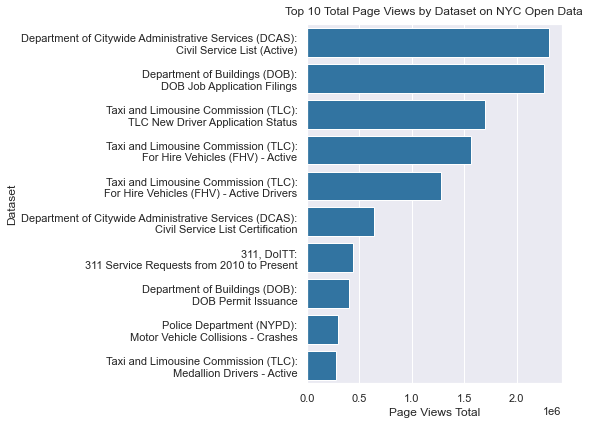

In [25]:
data = (df
 .loc[:, ['attribution', 'name', 'page_views_total']]
 .sort_values(by='page_views_total', ascending=False)
 .head(10)
)

data['full_name'] = data['attribution'] + ':\n' + data['name']

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=data,
    y='full_name',
    x='page_views_total',
    color='#1f77b4'
)

plt.title(
    'Top 10 Total Page Views by Dataset on NYC Open Data',
    fontsize=12, pad=10)
plt.xlabel('Page Views Total')
plt.ylabel('Dataset')
plt.tight_layout()

## 4. Analyzing NYC 311 Street Flooding Complaints

### 4.1 Searching the dataset for the word "flood" in the complaint_type field

In [26]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select complaint_type and count of complaint_type grouped by compaint_type,
where the word "flood" is in compplaint_type,
sort count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    complaint_type, 
    count(unique_key) AS count
WHERE 
    LOWER(complaint_type) LIKE '%flood%'
GROUP BY 
    complaint_type
ORDER BY 
    count(unique_key) DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df

shape of data: (0, 0)


""


### 4.2 Searching the dataset for the word "flood" in the descriptor field

In [27]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select complaint_type and count of complaint_type grouped by compaint_type,
where the word "flood" is in descriptor,
sort count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    complaint_type,
    descriptor,
    count(unique_key) AS count
WHERE 
    LOWER(descriptor) LIKE '%flood%'
GROUP BY 
    complaint_type, descriptor
ORDER BY 
    count(unique_key) DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df

shape of data: (11, 3)


,complaint_type,descriptor,count
0,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),107904
1,Sewer,Street Flooding (SJ),35918
2,Street Light Condition,Flood Light Lamp Out,6413
3,Sewer,Highway Flooding (SH),3075
4,Street Light Condition,Flood Light Lamp Cycling,2573
5,OEM Literature Request,Ready NY - Flooding,271
6,Street Light Condition,Flood Light Lamp Dayburning,223
7,Street Light Condition,Flood Light Lamp Missing,206
8,Street Light Condition,Flood Light Lamp Dim,184
9,Sewer,RAIN GARDEN FLOODING (SRGFLD),152


### 4. 3 Displaying the highest number of street flooding complaints by day

In [28]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=100
)

""" SoQL query string below:
Select the day and the count day columns grouped by day,
where the descriptor is Street Flooding (SJ),
sort the count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    date_trunc_ymd(created_date) as day, 
    count(created_date) AS count
WHERE 
    descriptor == 'Street Flooding (SJ)'
GROUP BY 
    day
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head(10)

shape of data: (1000, 2)


,day,count
0,2021-09-02T00:00:00.000,350
1,2021-09-01T00:00:00.000,344
2,2022-12-23T00:00:00.000,308
3,2017-05-05T00:00:00.000,247
4,2014-12-09T00:00:00.000,226
5,2014-04-30T00:00:00.000,189
6,2021-10-26T00:00:00.000,177
7,2018-04-16T00:00:00.000,163
8,2013-05-08T00:00:00.000,162
9,2021-08-22T00:00:00.000,158


In [29]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select the day and count day grouped by day,
sort by count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    date_trunc_ymd(created_date) AS day,
    complaint_type, 
    descriptor,
    count(unique_key) AS count
WHERE
    date_trunc_ymd(created_date) == '2021-09-02T00:00:00.000'
GROUP BY 
    day, complaint_type, descriptor
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head(10)

shape of data: (480, 4)


,day,complaint_type,descriptor,count
0,2021-09-02T00:00:00.000,Sewer,Sewer Backup (Use Comments) (SA),2372
1,2021-09-02T00:00:00.000,Request Large Bulky Item Collection,Request Large Bulky Item Collection,1350
2,2021-09-02T00:00:00.000,WATER LEAK,HEAVY FLOW,564
3,2021-09-02T00:00:00.000,Traffic Signal Condition,Controller,391
4,2021-09-02T00:00:00.000,Noise - Street/Sidewalk,Loud Music/Party,358
5,2021-09-02T00:00:00.000,Sewer,Street Flooding (SJ),350
6,2021-09-02T00:00:00.000,PAINT/PLASTER,CEILING,321
7,2021-09-02T00:00:00.000,Blocked Driveway,No Access,313
8,2021-09-02T00:00:00.000,Damaged Tree,Branch or Limb Has Fallen Down,303
9,2021-09-02T00:00:00.000,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),295


In [30]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=1000
)

""" SoQL query string below:
Select the day and count day grouped by day,
sort by count in descending order and limit our records to 1,000
"""

query = """
SELECT 
    date_trunc_ymd(created_date) AS day,
    complaint_type, 
    descriptor,
    count(unique_key) AS count
WHERE
    date_trunc_ymd(created_date) == '2022-12-23T00:00:00.000'
GROUP BY 
    day, complaint_type, descriptor
ORDER BY 
    count DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head(10)

shape of data: (424, 4)


,day,complaint_type,descriptor,count
0,2022-12-23T00:00:00.000,HEAT/HOT WATER,ENTIRE BUILDING,1524
1,2022-12-23T00:00:00.000,HEAT/HOT WATER,APARTMENT ONLY,870
2,2022-12-23T00:00:00.000,Blocked Driveway,No Access,373
3,2022-12-23T00:00:00.000,Traffic Signal Condition,Controller,322
4,2022-12-23T00:00:00.000,Illegal Parking,Blocked Hydrant,311
5,2022-12-23T00:00:00.000,Sewer,Street Flooding (SJ),308
6,2022-12-23T00:00:00.000,Noise - Residential,Loud Music/Party,250
7,2022-12-23T00:00:00.000,Noise - Residential,Banging/Pounding,210
8,2022-12-23T00:00:00.000,Illegal Parking,Posted Parking Sign Violation,187
9,2022-12-23T00:00:00.000,Damaged Tree,Entire Tree Has Fallen Down,167


### 4.4 Selecting the rows and columns where the descriptor field = 'Street Flooding'

In [31]:
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'erm2-nwe9'

client = Socrata(
    socrata_domain,
    app_token=None,
    timeout=100
)

""" SoQL query string below:
Select all columns where the descriptor is Street Flooding(SJ),
sort the created date field in descending order and limit our records to 1,000
"""

query = """
SELECT 
    *
WHERE 
    descriptor == 'Street Flooding (SJ)'
ORDER BY 
    created_date DESC
LIMIT 
    1000
"""

results = client.get(
    socrata_dataset_identifier,
    query=query
)
client.close()

results_df = pd.DataFrame.from_records(results)

print('shape of data:', results_df.shape)
results_df.head()

shape of data: (1000, 30)


,unique_key,created_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,cross_street_1,...,park_facility_name,park_borough,latitude,longitude,location,closed_date,resolution_description,resolution_action_updated_date,intersection_street_1,intersection_street_2
0,58141200,2023-07-08T16:32:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11432,88-34 162 STREET,162 STREET,HILLSIDE AVE,...,Unspecified,QUEENS,40.707751910376196,-73.79980764202126,"{'latitude': '40.707751910376196', 'longitude'...",NaN,NaN,NaN,NaN,NaN
1,58135548,2023-07-08T10:59:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11235,136 EXETER STREET,EXETER STREET,HAMPTON AVE,...,Unspecified,BROOKLYN,40.578832736931304,-73.94851769423227,"{'latitude': '40.578832736931304', 'longitude'...",NaN,NaN,NaN,NaN,NaN
2,58135558,2023-07-08T07:14:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11377,28-00 56 PLACE,56 PLACE,28 AVE,...,Unspecified,QUEENS,40.76102786535735,-73.9048431925931,"{'latitude': '40.76102786535735', 'longitude':...",NaN,NaN,NaN,NaN,NaN
3,58132135,2023-07-07T21:11:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11225,563 EMPIRE BOULEVARD,EMPIRE BOULEVARD,LAMONT CT,...,Unspecified,BROOKLYN,40.66410557687251,-73.94351730372368,"{'latitude': '40.66410557687251', 'longitude':...",NaN,NaN,NaN,NaN,NaN
4,58125333,2023-07-07T21:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11214,2111 83 STREET,83 STREET,21 AVE,...,Unspecified,BROOKLYN,40.60470560403262,-73.99376614214772,"{'latitude': '40.60470560403262', 'longitude':...",NaN,NaN,NaN,NaN,NaN
